In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from skopt.space import Real, Categorical

In [82]:
dataset_path = '../DATASET/INITIAL_DATASET'
train_path = os.path.join(dataset_path, 'train.csv')
test_path = os.path.join(dataset_path, 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [83]:
train_df['source'] = 'train'
test_df['source'] = 'test'

full_df = pd.concat([train_df, test_df], ignore_index=True)

In [84]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [85]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [86]:
result = pd.concat([train_df.isna().sum(),train_df.isna().mean()],axis=1)
result

,0,1
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [87]:
grouped = full_df.groupby(["Sex", "Pclass"])["Age"]

summary = grouped.agg(
    missing_percentage=lambda x: x.isna().mean() * 100,
    count="count"  # number of non-missing Age values
)

# To include total number of records (including NaN Age)
summary["total_records"] = grouped.size()

print(summary)

               missing_percentage  count  total_records
Sex    Pclass                                          
female 1                 7.638889    133            144
       2                 2.830189    103            106
       3                29.629630    152            216
male   1                15.642458    151            179
       2                 7.602339    158            171
       3                29.208925    349            493


In [88]:
full_df["Title"] = full_df["Name"].str.split(",").str[1].str.strip().str.split(" ").str[0]
pclass3 = full_df[full_df["Pclass"] == 3]

# Get all unique titles
unique_titles = pclass3["Title"].unique()

print("Unique titles in Pclass 3:")
print(unique_titles)
print(full_df["Title"].unique())

Unique titles in Pclass 3:
['Mr.' 'Miss.' 'Master.' 'Mrs.' 'Ms.']
['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.' 'Dona.']


In [89]:
# Group by Title
title_summary = full_df.groupby("Title")["Age"].agg(
    average_age=lambda x: x.mean(),                # mean age
    missing_percentage=lambda x: x.isna().mean() * 100, # % of missing ages
    count=lambda x: x.size
)

print(title_summary)

           average_age  missing_percentage  count
Title                                            
Capt.        70.000000            0.000000      1
Col.         54.000000            0.000000      4
Don.         40.000000            0.000000      1
Dona.        39.000000            0.000000      1
Dr.          43.571429           12.500000      8
Jonkheer.    38.000000            0.000000      1
Lady.        48.000000            0.000000      1
Major.       48.500000            0.000000      2
Master.       5.482642           13.114754     61
Miss.        21.774238           19.230769    260
Mlle.        24.000000            0.000000      2
Mme.         24.000000            0.000000      1
Mr.          32.252151           23.249670    757
Mrs.         36.994118           13.705584    197
Ms.          28.000000           50.000000      2
Rev.         41.250000            0.000000      8
Sir.         49.000000            0.000000      1
the          33.000000            0.000000      1


In [90]:
print(f'Age mean:{full_df["Age"].mean()}')
print(f'Age median:{full_df["Age"].median()}')

Age mean:29.881137667304014
Age median:28.0


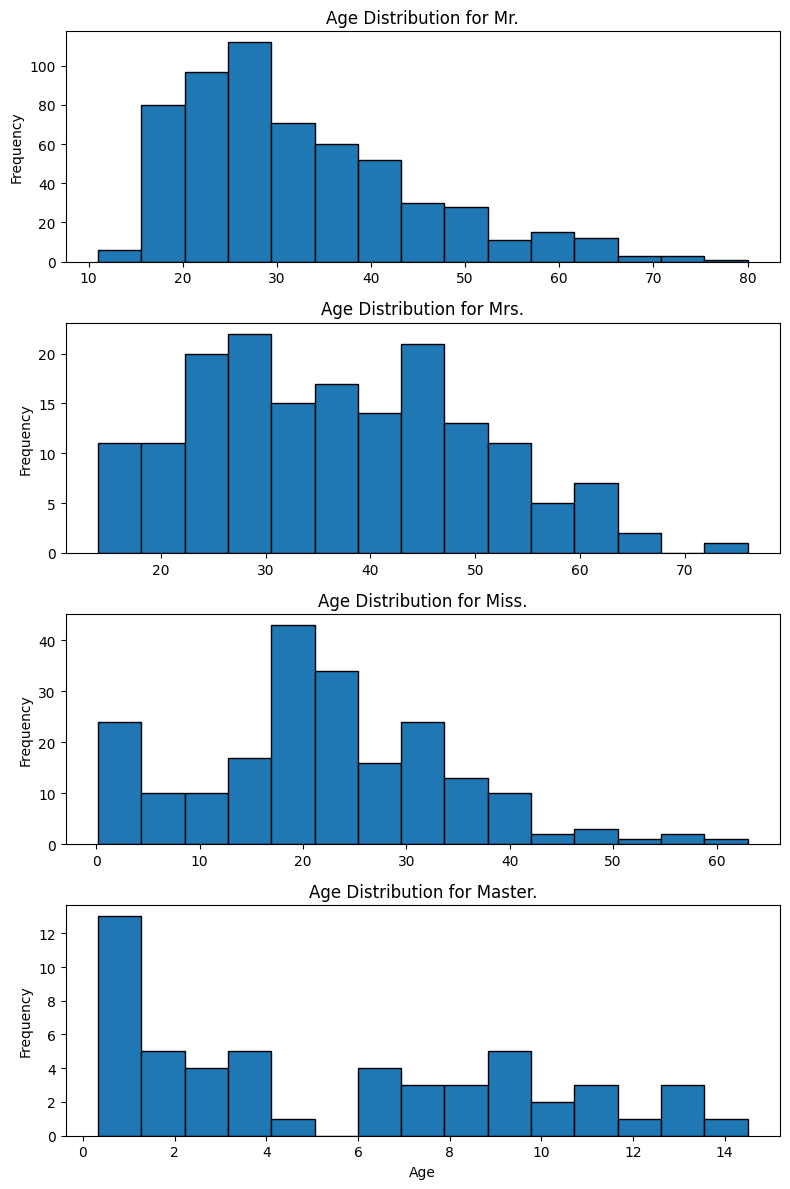

In [94]:
df_before_age_imp = full_df.copy()
titles_to_plot = ["Mr.", "Mrs.", "Miss.", "Master."]

fig, axes = plt.subplots(len(titles_to_plot), 1, figsize=(8, 12), sharex=False)
age_data_before = df_before_age_imp.loc[full_df["Title"] == title, "Age"].dropna()

for ax, title in zip(axes, titles_to_plot):
    age_data_before = df_before_age_imp.loc[df_before_age_imp["Title"] == title, "Age"].dropna()
    ax.hist(age_data_before, bins=15, edgecolor="black")
    ax.set_title(f"Age Distribution for {title}")
    ax.set_ylabel("Frequency")

plt.xlabel("Age")
plt.tight_layout()
plt.show()

In [95]:
max_age_master = full_df.loc[full_df['Title'] == 'Master.', 'Age'].dropna().max()
min_age_mr = full_df.loc[full_df['Title'] == 'Mr.', 'Age'].dropna().min()

print(f"The maximum age for title Master. is: {max_age_master}")
print(f"The minimum age for title Mr. is: {min_age_mr}")

mr_below_15 = full_df.loc[(full_df['Title'] == 'Mr.') & (full_df['Age'] < 15)]

print(f"The number of Mr. with age below 15 is: {mr_below_15}")

full_df.loc[(full_df['Title'] == 'Master.') & (full_df['Age'] == 14), 'Title'] = 'Mr.'

full_df.loc[(full_df['Title'] == 'Mr.') & (full_df['Age'] == 11), 'Title'] = 'Master.'


The maximum age for title Master. is: 14.5
The minimum age for title Mr. is: 11.0
The number of Mr. with age below 15 is:       PassengerId  Survived  Pclass                         Name   Sex   Age  \
683           684       0.0       3  Goodwin, Mr. Charles Edward  male  14.0   
686           687       0.0       3     Panula, Mr. Jaako Arnold  male  14.0   
731           732       0.0       3     Hassan, Mr. Houssein G N  male  11.0   
896           897       NaN       3   Svensson, Mr. Johan Cervin  male  14.0   
1121         1122       NaN       2  Sweet, Mr. George Frederick  male  14.0   

      SibSp  Parch   Ticket     Fare Cabin Embarked source Title  
683       5      2  CA 2144  46.9000   NaN        S  train   Mr.  
686       4      1  3101295  39.6875   NaN        S  train   Mr.  
731       0      0     2699  18.7875   NaN        C  train   Mr.  
896       0      0     7538   9.2250   NaN        S   test   Mr.  
1121      0      0   220845  65.0000   NaN        S   test   M

In [96]:
train_df = full_df[full_df["source"] == "train"]

# Group by Title and calculate summary
title_summary = train_df.groupby("Title").agg(
    total_passengers=("Survived", "count"),       # total number of passengers per title
    survival_percentage=("Survived", lambda x: x.mean() * 100)  # % survived
).sort_values(by="survival_percentage", ascending=False)

print(title_summary)

           total_passengers  survival_percentage
Title                                           
the                       1           100.000000
Mlle.                     2           100.000000
Sir.                      1           100.000000
Ms.                       1           100.000000
Lady.                     1           100.000000
Mme.                      1           100.000000
Mrs.                    125            79.200000
Miss.                   182            69.780220
Master.                  41            56.097561
Col.                      2            50.000000
Major.                    2            50.000000
Dr.                       7            42.857143
Mr.                     516            15.697674
Jonkheer.                 1             0.000000
Rev.                      6             0.000000
Don.                      1             0.000000
Capt.                     1             0.000000


In [97]:
def encode_title(title):
    if title in ["Mr."]:
        return "Mr"
    elif title in ["Mrs.", "Mme."]:
        return "Mrs"
    elif title in ["Miss.", "Mlle.", "Ms."]:
        return "Miss"
    elif title == "Master.":
        return "Master"
    else:
        return "Rare"

# Apply encoding
full_df["Title_Encoded"] = full_df["Title"].apply(encode_title)

# Check distribution
print(full_df["Title_Encoded"].value_counts())

Title_Encoded
Mr        756
Miss      264
Mrs       198
Master     62
Rare       29
Name: count, dtype: int64


In [98]:
# Filter for training dataset
train_df = full_df[full_df["source"] == "train"]

# Calculate survival percentage by Title
survival_by_title = train_df.groupby("Title_Encoded")["Survived"].agg(
    total_passengers="count",
    survival_percentage=lambda x: x.mean() * 100
)

print(survival_by_title)

               total_passengers  survival_percentage
Title_Encoded                                       
Master                       41            56.097561
Miss                        185            70.270270
Mr                          516            15.697674
Mrs                         126            79.365079
Rare                         23            34.782609


In [99]:
df = full_df.copy()
le = LabelEncoder()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

In [100]:
larger_dataset = "y"
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Embarked'] = df['Embarked'].replace(3, np.nan)
ohetransform = ohe.fit_transform(df[['Sex']])
df = pd.concat([df, ohetransform], axis=1).drop(columns=['Sex'])
full_df = pd.concat([full_df, ohetransform], axis=1).drop(columns=['Sex'])
if larger_dataset == 'y':
    ohetransform = ohe.fit_transform(df[['Title_Encoded']])
    df = pd.concat([df, ohetransform], axis=1).drop(columns='Title_Encoded')
    full_df = pd.concat([full_df, ohetransform], axis=1).drop(columns="Title_Encoded")

In [101]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'source', 'Title', 'Sex_female',
       'Sex_male', 'Title_Encoded_Master', 'Title_Encoded_Miss',
       'Title_Encoded_Mr', 'Title_Encoded_Mrs', 'Title_Encoded_Rare'],
      dtype='object')

In [102]:
if larger_dataset == 'y':
    features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_male', 'Sex_female',
               'Title_Encoded_Master', 'Title_Encoded_Miss',
                'Title_Encoded_Mr', 'Title_Encoded_Mrs', 'Title_Encoded_Rare'] 
elif larger_dataset == 'n':
    features = ['Pclass', 'Age','SibSp', 'Parch', 'Sex_male', 'Sex_female']
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)

In [103]:
names = full_df["Name"].str.split(" ").str[0]
print(full_df.loc[full_df["Fare"].isna(), "Name"])
print(names.value_counts().get("Storey,",0))

1043    Storey, Mr. Thomas
Name: Name, dtype: object
1


In [104]:
full_df.loc[full_df["Fare"].isna()]
mean_fare_p3 = full_df.loc[full_df["Pclass"]==3, "Fare"].median()
full_df['Fare'] = full_df["Fare"].fillna(mean_fare_p3)

In [105]:
max_fare_p3 = full_df.loc[full_df["Pclass"] == 3, "Fare"].max()

# Get the name(s) of the passenger(s) with this fare
names_max_fare_p3 = full_df.loc[(full_df["Pclass"] == 3) & (full_df["Fare"] == max_fare_p3), "Name"]

print(f"The maximum fare for Pclass 3 is: {max_fare_p3}")
print("Passenger(s) with this fare:")
print(names_max_fare_p3.tolist())

The maximum fare for Pclass 3 is: 69.55
Passenger(s) with this fare:
['Sage, Master. Thomas Henry', 'Sage, Miss. Constance Gladys', 'Sage, Mr. Frederick', 'Sage, Mr. George John Jr', 'Sage, Miss. Stella Anna', 'Sage, Mr. Douglas Bullen', 'Sage, Miss. Dorothy Edith "Dolly"', 'Sage, Miss. Ada', 'Sage, Mr. John George', 'Sage, Master. William Henry', 'Sage, Mrs. John (Annie Bullen)']


In [106]:
full_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'source', 'Title', 'Sex_female',
       'Sex_male', 'Title_Encoded_Master', 'Title_Encoded_Miss',
       'Title_Encoded_Mr', 'Title_Encoded_Mrs', 'Title_Encoded_Rare'],
      dtype='object')

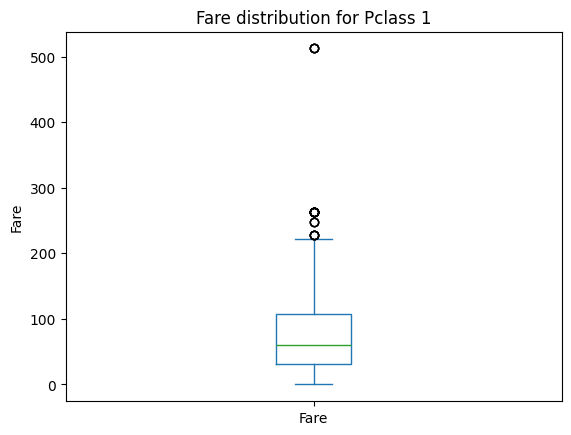

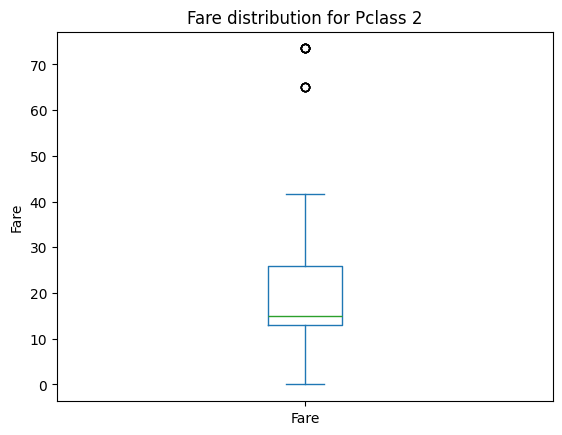

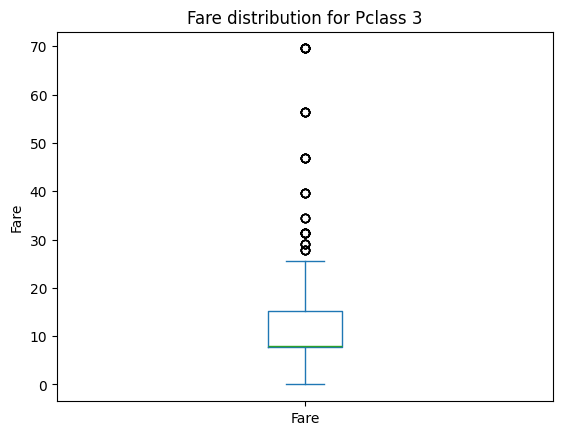

In [107]:
import matplotlib.pyplot as plt

for pclass in sorted(full_df["Pclass"].unique()):
    plt.figure()
    full_df.loc[full_df["Pclass"] == pclass, "Fare"].plot.box()
    plt.title(f"Fare distribution for Pclass {pclass}")
    plt.ylabel("Fare")
    plt.show()

In [108]:
full_df["Embarked"] = full_df["Embarked"].fillna("S")
ohetransform = ohe.fit_transform(full_df[['Embarked']])
full_df = pd.concat([full_df, ohetransform], axis=1).drop(columns='Embarked')


In [109]:
full_df['Age_missing'] = full_df['Age'].isna().astype(int)

In [110]:
full_df['Age'] = full_df['Age'].fillna(df_imputed['Age'])

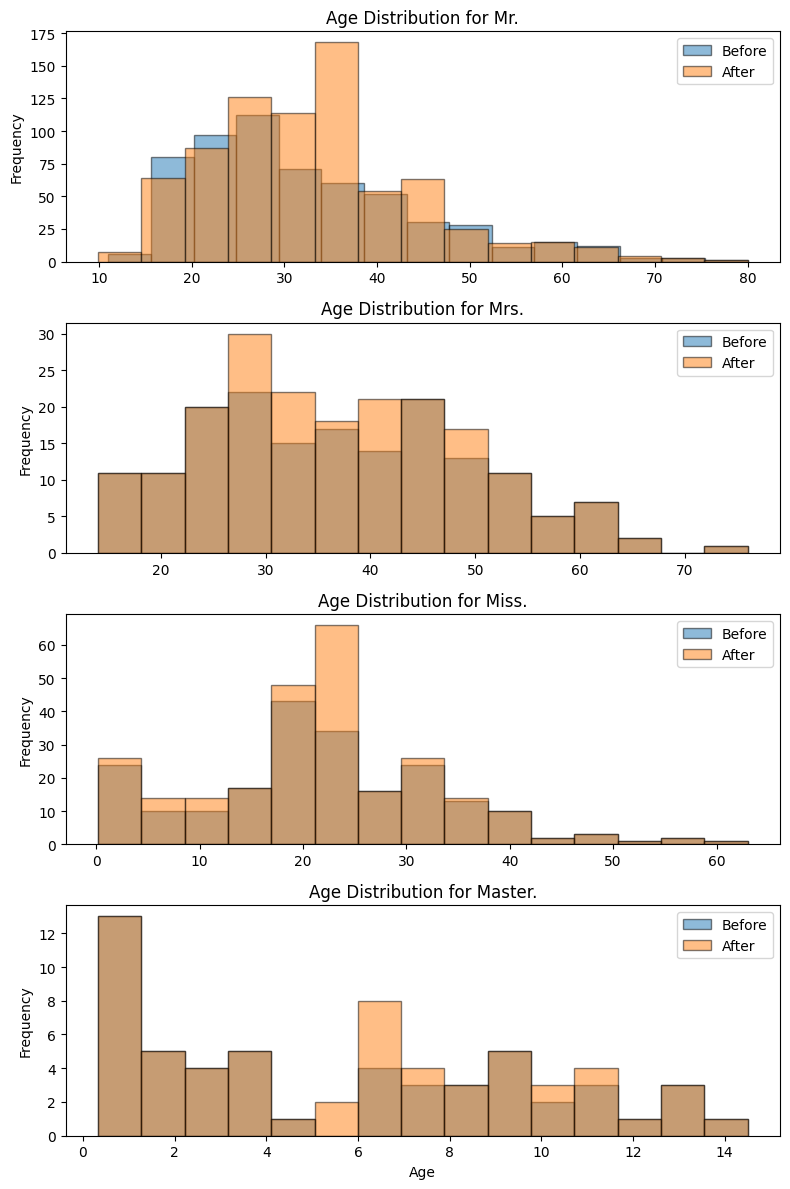

In [112]:
df_after_age_imp = full_df.copy()

titles_to_plot = ["Mr.", "Mrs.", "Miss.", "Master."]

fig, axes = plt.subplots(len(titles_to_plot), 1, figsize=(8, 12), sharex=False)


for ax, title in zip(axes, titles_to_plot):
    age_before = df_before_age_imp.loc[df_before_age_imp["Title"] == title, "Age"]
    age_after  = df_after_age_imp.loc[df_after_age_imp["Title"] == title, "Age"]

    ax.hist(age_before, bins=15, alpha=0.5, label="Before", edgecolor="black")
    ax.hist(age_after,  bins=15, alpha=0.5, label="After",  edgecolor="black")
    
    ax.set_title(f"Age Distribution for {title}")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.xlabel("Age")
plt.tight_layout()
plt.show()

In [2]:
dataset_name = "base_dataset.csv"
full_path = os.path.join('../DATASET/BASE_DATASET/', dataset_name)
full_df.to_csv(full_path)

NameError: name 'full_df' is not defined

In [3]:
dataset_path = '../DATASET/BASE_DATASET/base_dataset.csv'
df = pd.read_csv(dataset_path)

In [4]:
train_df = df[df['source']=='train'].copy().drop(columns=['source', 'Name', 'Ticket', 'Cabin', 
                                                                    'Title'])
test_df = df[df['source']=='test'].copy().drop(columns=['source', 'Name', 'Ticket', 'Cabin', 
                                                                    'Title'])

In [113]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age_missing','Title_Encoded_Master', 
                                                                    'Title_Encoded_Miss', 
                                                                    'Title_Encoded_Mrs', 
                                                                    'Title_Encoded_Rare']
X_train = train_df[features]
y_train = train_df['Survived']

X_test = test_df[features]

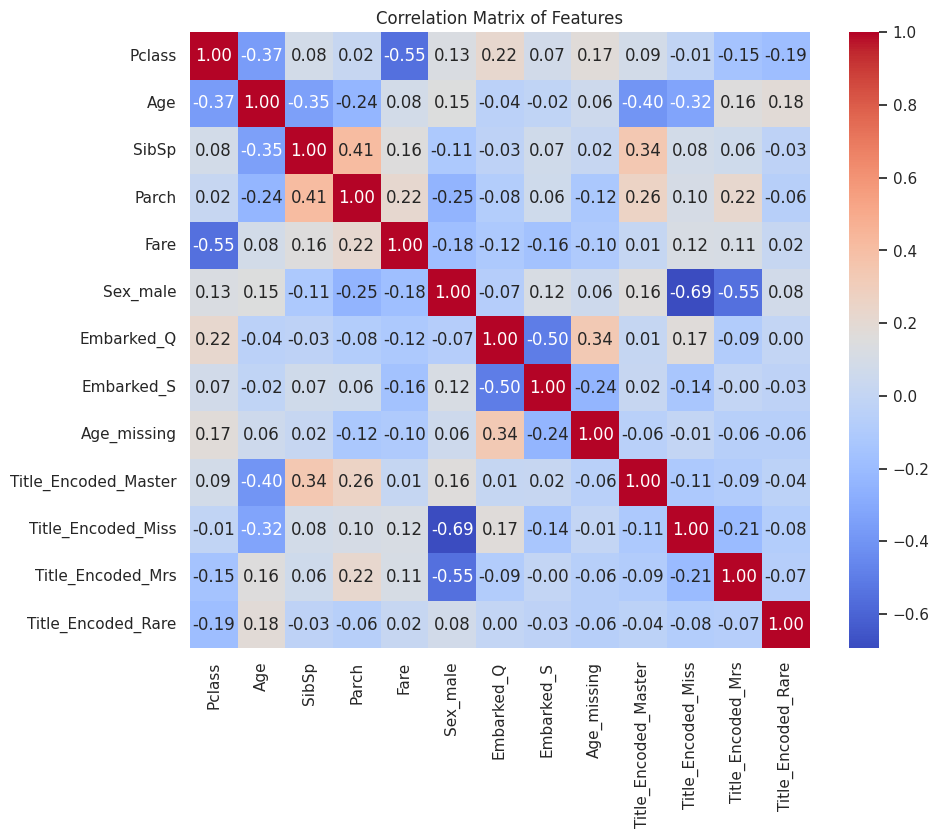

In [114]:
# Assuming your DataFrame is called df
plt.figure(figsize=(10, 8))

# Compute correlation matrix for 
corr_matrix = X_train.corr()

# Plot heatmap to see correlation between dual variables
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()


In [115]:
#Implement Variance Inflation Factor two check collinearity between 2 or more variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame for VIF results
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(len(X_train.columns))]

print(vif_data)

                 Feature        VIF
0                 Pclass  15.799255
1                    Age  10.174531
2                  SibSp   1.749874
3                  Parch   1.736568
4                   Fare   2.319892
5               Sex_male  25.246914
6             Embarked_Q   1.748802
7             Embarked_S   5.364745
8            Age_missing   1.510062
9   Title_Encoded_Master   1.519447
10    Title_Encoded_Miss   7.086836
11     Title_Encoded_Mrs   6.133188
12    Title_Encoded_Rare   1.108222


In [116]:
test_dataset = X_train.copy()
test_dataset = test_dataset.drop(columns=['Title_Encoded_Miss', 'Title_Encoded_Mrs', 'Title_Encoded_Rare', 'Title_Encoded_Master'])

vif_data = pd.DataFrame()
vif_data["Feature"] = test_dataset.columns
vif_data["VIF"] = [variance_inflation_factor(test_dataset.values, i)
                   for i in range(len(test_dataset.columns))]

print(vif_data)

       Feature       VIF
0       Pclass  6.715391
1          Age  4.857156
2        SibSp  1.655691
3        Parch  1.645604
4         Fare  1.693550
5     Sex_male  3.229999
6   Embarked_Q  1.684152
7   Embarked_S  4.940117
8  Age_missing  1.497266


In [117]:
X_train = X_train.drop(columns=['Title_Encoded_Miss', 'Title_Encoded_Mrs', 'Title_Encoded_Rare', 'Title_Encoded_Master'])
X_test = X_test.drop(columns=['Title_Encoded_Miss', 'Title_Encoded_Mrs', 'Title_Encoded_Rare', 'Title_Encoded_Master'])

In [118]:
#box tidwell test
continuous_variables = ['Fare', 'Age']
variables_to_keep = X_train[continuous_variables]
for var in continuous_variables:
    variables_to_keep[f'{var}:Log_{var}'] = variables_to_keep[var].apply(lambda x: x * np.log1p(x)) #np.log = natural log

/tmp/ipykernel_10900/502582203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_to_keep[f'{var}:Log_{var}'] = variables_to_keep[var].apply(lambda x: x * np.log1p(x)) #np.log = natural log
/tmp/ipykernel_10900/502582203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables_to_keep[f'{var}:Log_{var}'] = variables_to_keep[var].apply(lambda x: x * np.log1p(x)) #np.log = natural log


In [119]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

X_lt_constant = sm.add_constant(variables_to_keep, prepend=False)
logit_model = GLM(y_train, X_lt_constant, family=families.Binomial())
result = logit_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      886
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -539.80
Date:                Thu, 04 Sep 2025   Deviance:                       1079.6
Time:                        18:34:37   Pearson chi2:                     891.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1132
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Fare              0.0832      0.013      6.465

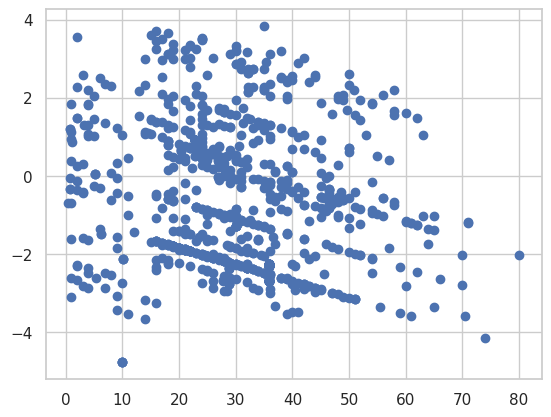

In [123]:
X_train_constant = sm.add_constant(X_train, prepend=False)
logit_results = GLM(y_train, X_train_constant, family=families.Binomial()).fit()
predicted = logit_results.predict(X_train_constant)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x=X_train_constant['Age'].values, y=log_odds);
plt.show()

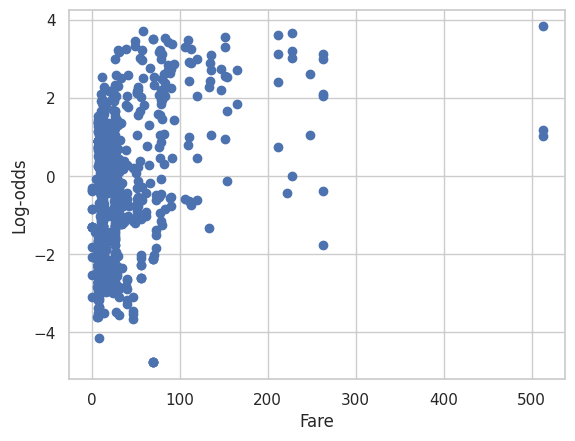

In [126]:
plt.scatter(x=X_train_constant['Fare'].values, y=log_odds);
plt.xlabel("Fare")
plt.ylabel("Log-odds")
plt.show()

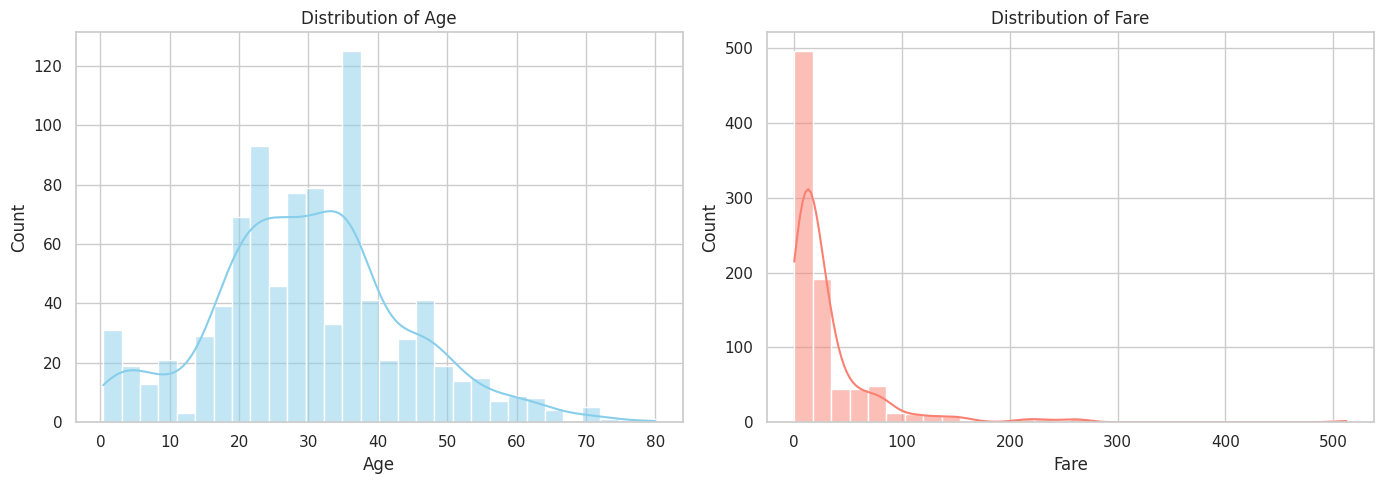

In [109]:
sns.set(style="whitegrid")

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of Age
sns.histplot(X_train["Age"], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribution of Age")

# Distribution of Fare
sns.histplot(X_train["Fare"], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribution of Fare")

plt.tight_layout()
plt.show()

In [110]:
X_train["Fare_squared"] = X_train["Fare"] ** 2
X_test["Fare_squared"] = X_test["Fare"] ** 2

In [111]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_train["Fare"] = scaler.fit_transform(X_train[["Fare"]])
X_test["Fare"] = scaler.transform(X_test[["Fare"]])

X_train["Fare_squared"] = scaler.fit_transform(X_train[["Fare_squared"]])
X_test["Fare_squared"] = scaler.transform(X_test[["Fare_squared"]])

X_train["Age"] = scaler.fit_transform(X_train[["Age"]])
X_test["Age"] = scaler.transform(X_test[["Age"]])

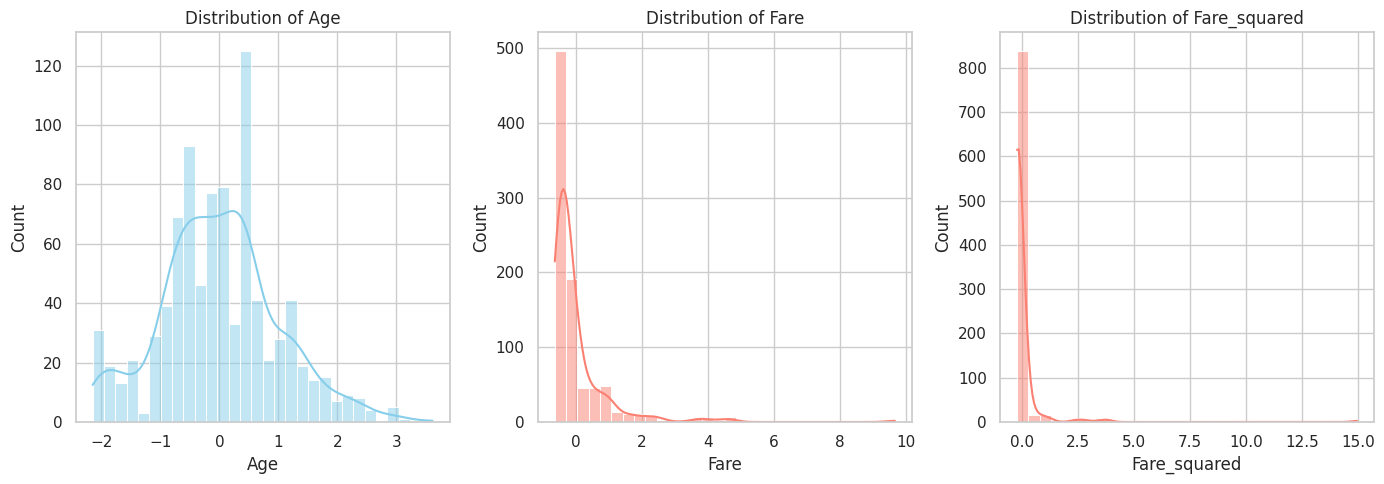

In [112]:
sns.set(style="whitegrid")

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Distribution of Age
sns.histplot(X_train["Age"], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribution of Age")

# Distribution of Fare
sns.histplot(X_train["Fare"], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribution of Fare")

sns.histplot(X_train["Fare_squared"], bins=30, kde=True, ax=axes[2], color='salmon')
axes[2].set_title("Distribution of Fare_squared")

plt.tight_layout()
plt.show()

In [94]:
p_grid_lr = {"C" : np.logspace(-3, 2, 20),
             "penalty": ['l1', 'l2'],
             "solver": ['liblinear', 'saga']}

lr = LogisticRegression(max_iter=5_000, random_state=42)

[0.82489486 0.82379009 0.82153663 0.82714833 0.82830959 0.82045697
 0.82153035 0.8248823  0.82161195 0.82606867]
[0.82826565 0.8294018  0.82938924 0.82827192 0.83167409 0.82719854
 0.82377754 0.82711694 0.82610633 0.82719854]
Average difference of 0.003817 with std. dev. of 0.002199.


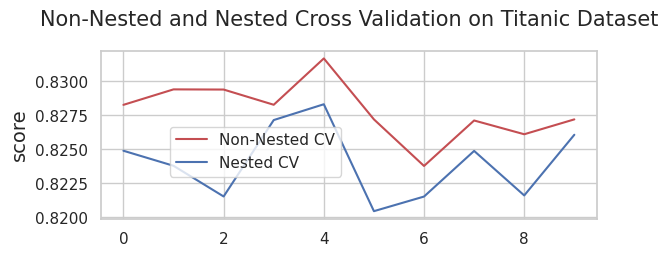

In [101]:
NUM_ITERS = 10



non_nested_scores = np.zeros(NUM_ITERS)
nested_scores = np.zeros(NUM_ITERS)




for i in range(NUM_ITERS):
    inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    
    clf = GridSearchCV(estimator=lr, param_grid=p_grid_lr, cv=outer_skf, n_jobs=-1)
    
    clf.fit(X_train, y_train)
    non_nested_scores[i] = clf.best_score_

    clf = GridSearchCV(estimator=lr, param_grid=p_grid_lr, cv=inner_skf, n_jobs=-1)
    nested_score = cross_val_score(clf, X=X_train, y=y_train, cv=outer_skf)
    nested_scores[i] = nested_score.mean()
    
print(nested_scores)
print(non_nested_scores)

plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Titanic Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)


In [95]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_clf = GridSearchCV(estimator=lr, param_grid=p_grid_lr, cv=skf, n_jobs=-1)
final_clf.fit(X_train, y_train)

print("Best params:", final_clf.best_params_)

Best params: {'C': np.float64(0.23357214690901212), 'penalty': 'l2', 'solver': 'saga'}


In [97]:
y_test_pred = final_clf.predict(X_test).astype(int)
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": y_test_pred
})


submission.to_csv("grid_logistic.csv", index=False) # 77.03

In [98]:
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'],
                     solver=['liblinear', 'saga'])

clf = RandomizedSearchCV(lr, distributions, random_state=42, n_jobs=-1, cv=skf, n_iter=1000)
clf.fit(X_train, y_train)

print("Best params:", clf.best_params_)


Best params: {'C': np.float64(0.2059150049999574), 'penalty': 'l2', 'solver': 'saga'}


In [99]:
y_test_pred = clf.predict(X_test).astype(int)
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": y_test_pred
})


submission.to_csv("random_logistic.csv", index=False) # 77.03

In [100]:
search_space_bayes_lr = {
    'C': Real(0.01, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['liblinear', 'saga'])
}

bayes_search = BayesSearchCV(
    lr,
    search_spaces=search_space_bayes_lr,
    n_iter=30,                   
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

bayes_search.fit(X_train, y_train)

print("Best hyperparameters:", bayes_search.best_params_)
print("Best CV accuracy:", bayes_search.best_score_)

Best hyperparameters: OrderedDict([('C', 0.22796041928002214), ('penalty', 'l2'), ('solver', 'saga')])
Best CV accuracy: 0.8047203565375682


In [101]:
y_test_pred = bayes_search.predict(X_test).astype(int)
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": y_test_pred
})


submission.to_csv("bayesian_logistic.csv", index=False) # 76.07